In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
import tensorflow as tf
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import time
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


In [3]:

# Define the dataset class (already defined in your code)
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, filenames, labels, transform=None):
        self.root_dir = root_dir
        self.filenames = filenames
        self.labels = labels  # This should be a list of labels
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(img_name)

        # Get the label from the labels list
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and label


In [4]:
# Setup the transforms for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to match the input size of ResNet18
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset for training and testing
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

# Load CIFAR-10 test set for evaluation
testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader_cifar = DataLoader(testset_cifar, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Load pre-trained ResNet18 model and modify the output layer
model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 classes for CIFAR-10
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

In [8]:
# Pre-tuning Training Loop
EPOCHS = 7
BATCH_SIZE = 32

# Lists to track accuracy and loss
avg_train_accuracy_history = []
avg_test_accuracy_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()

    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    avg_train_accuracy_history.append(epoch_accuracy)

    # Testing accuracy on the test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data, target in testloader_cifar:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()
 
    test_accuracy = 100 * correct_test / total_test
    avg_test_accuracy_history.append(test_accuracy)

    end_time = time.time()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Time: {end_time - start_time:.2f}s")

Epoch [1/7], Loss: 0.5814, Train Accuracy: 80.24%, Test Accuracy: 85.55%, Time: 768.92s
Epoch [2/7], Loss: 0.3414, Train Accuracy: 88.41%, Test Accuracy: 87.21%, Time: 770.97s
Epoch [3/7], Loss: 0.2455, Train Accuracy: 91.50%, Test Accuracy: 90.00%, Time: 769.10s
Epoch [4/7], Loss: 0.1776, Train Accuracy: 93.86%, Test Accuracy: 90.43%, Time: 777.51s
Epoch [5/7], Loss: 0.1344, Train Accuracy: 95.30%, Test Accuracy: 89.75%, Time: 774.25s
Epoch [6/7], Loss: 0.1059, Train Accuracy: 96.26%, Test Accuracy: 89.74%, Time: 769.34s
Epoch [7/7], Loss: 0.0844, Train Accuracy: 97.07%, Test Accuracy: 90.61%, Time: 767.83s


In [42]:
def get_test():
    test_loss = []
    correct = 0
    incorrect = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for batch_idx, (data, target) in enumerate(trainloader):
        if batch_idx == STEPS_PER_TEST_EPOCH:
            break

        # Model is used to predict the test data so we are switching off the gradient
        with torch.no_grad():

            data = data.to(device)
            target = target.long().to(device)
            output = model(data)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, target)

            # Note that optimizer is not used because the model shouldn't learn the test dataset

            # Iterate over the current batch size, not a fixed BATCH_SIZE
            for i in range(data.size(0)):  # Use the actual batch size
                a = [float(j.detach()) for j in output[i]]
                pred = a.index(max(a))

                if pred == int(target[i]):
                    correct += 1
                else:
                    incorrect += 1

        test_loss.append(float(loss.detach()))
    
    print("CORRECT: " + str(correct), "INCORRECT: " + str(incorrect), "TEST ACCURACY: " + str(correct/(correct+incorrect)))
    
    return (
        correct / (incorrect + correct),
        sum(test_loss) / len(test_loss),
    )


In [43]:
# Hyperparameters
EPOCHS = 7
BATCH_SIZE = 32
STEPS_PER_EPOCH = len(trainloader)  # Number of batches in an epoch
STEPS_PER_TEST_EPOCH = len(testloader_cifar)  # Number of test batches

# Lists to track accuracy and loss
avg_train_loss_history = []
avg_train_accuracy_history = []
avg_test_loss_history = []
avg_test_accuracy_history = []

loss_history = []
accuracy_history = []

new_best = 0

# Training Loop
for i in range(EPOCHS):
    start = time.time()
    print(f"----------------------- EPOCH {i} -----------------------------------")
    
    # Train the model
    model.train()
    correct = 0
    incorrect = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        if batch_idx == STEPS_PER_EPOCH:
            break

        optimizer.zero_grad()  # Reset gradients
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss
        loss_history.append(loss.detach())

        # Track train accuracy
        for p in range(data.size(0)):  # Dynamically set the loop to batch size
            a = [float(j.detach()) for j in output[p]]
            pred = a.index(max(a))
            if pred == int(target[p]):
                correct = correct + 1
            else:
                incorrect = incorrect + 1

        
        accuracy_history.append(correct / (correct + incorrect))

        print(f"\r EPOCH {i} MINIBATCH: {batch_idx}/{STEPS_PER_EPOCH} LOSS: {loss_history[-1]:.4f}", end="")

    end = time.time()
    print(f"\nEPOCH {i} TRAIN LOSS: {sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH:.4f} "
          f"TRAIN ACCURACY: {sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH:.4f} "
          f"ETA: {end - start:.2f}s")

    avg_train_loss_history.append(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    avg_train_accuracy_history.append(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    # Test the model
    test_acc, test_loss = get_test()

    avg_test_accuracy_history.append(test_acc)
    avg_test_loss_history.append(test_loss)

    # Save the best model based on test accuracy
    if test_acc > new_best:
        new_best = test_acc
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model

----------------------- EPOCH 0 -----------------------------------
 EPOCH 0 MINIBATCH: 1562/1563 LOSS: 0.0201
EPOCH 0 TRAIN LOSS: 0.0382 TRAIN ACCURACY: 0.9872 ETA: 252.93s
CORRECT: 9855 INCORRECT: 161 TEST ACCURACY: 0.9839257188498403
----------------------- EPOCH 1 -----------------------------------
 EPOCH 1 MINIBATCH: 1562/1563 LOSS: 0.0560
EPOCH 1 TRAIN LOSS: 0.0375 TRAIN ACCURACY: 0.9889 ETA: 257.93s
CORRECT: 9897 INCORRECT: 119 TEST ACCURACY: 0.9881190095846646
----------------------- EPOCH 2 -----------------------------------
 EPOCH 2 MINIBATCH: 1562/1563 LOSS: 0.0016
EPOCH 2 TRAIN LOSS: 0.0379 TRAIN ACCURACY: 0.9858 ETA: 254.05s
CORRECT: 9868 INCORRECT: 148 TEST ACCURACY: 0.985223642172524
----------------------- EPOCH 3 -----------------------------------
 EPOCH 3 MINIBATCH: 1562/1563 LOSS: 0.4634
EPOCH 3 TRAIN LOSS: 0.0362 TRAIN ACCURACY: 0.9885 ETA: 253.76s
CORRECT: 9883 INCORRECT: 133 TEST ACCURACY: 0.9867212460063898
----------------------- EPOCH 4 ---------------------

In [50]:
# Final Test on Best Model
print("\nEvaluating the Best Model on the Test Set:")
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

test_acc, test_loss = get_test()
print(f"Final Test Accuracy of Best Model: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Evaluating the Best Model on the Test Set:
CORRECT: 9946 INCORRECT: 70 TEST ACCURACY: 0.9930111821086262
Final Test Accuracy of Best Model: 0.9930, Test Loss: 0.0213


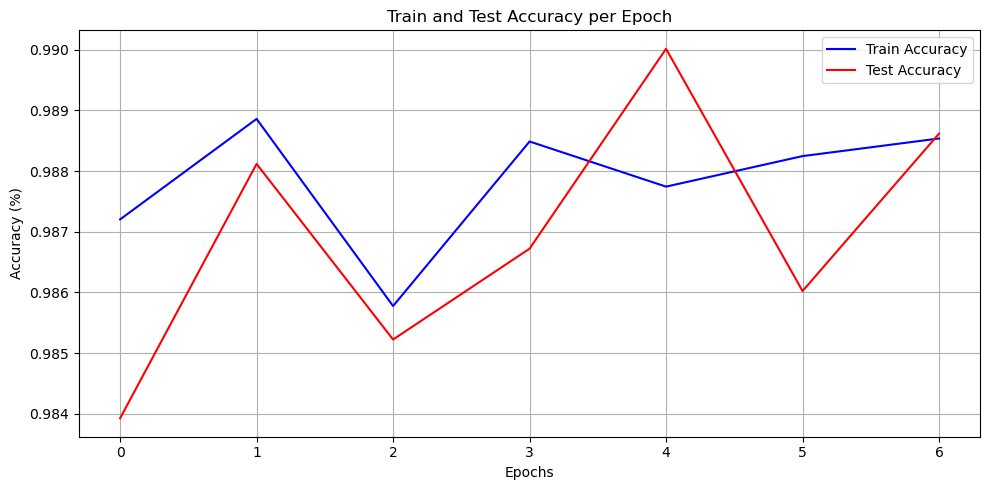

In [52]:
# Optionally, plot accuracy and loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(avg_train_accuracy_history, label='Train Accuracy', color='blue')
plt.plot(avg_test_accuracy_history, label='Test Accuracy', color='red')
plt.title('Train and Test Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()